<a href="https://colab.research.google.com/github/mrtalhim/ttow-ML/blob/main/wayang_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unzip the dataset. The dataset contains 4 classes and needs to be split into train and validation later.

In [2]:
import os
import zipfile

# local_zip = '/content/wayang-edited-final.zip'
local_zip = '/content/wayang-final-dataset.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [3]:
base_dir = '/content/augmented/'

In [4]:
IMG_WIDTH = 175
IMG_HEIGHT = 225

IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_SHAPE = IMG_SIZE + (3,)

In [5]:
import tensorflow as tf

In [6]:
train_batch = 40
train_epoch = 80
val_batch = 40
val_epoch = 20

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   horizontal_flip = True,
                                  #  width_shift_range = 0.1,
                                  #  height_shift_range = 0.1,
                                  #  fill_mode = 'nearest',
                                  #  rotation_range=15,
                                   zoom_range=0.2,
                                   validation_split=0.2
                                   )


train_generator = train_datagen.flow_from_directory(base_dir,
                                                    batch_size=train_batch,
                                                    class_mode='categorical',
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    shuffle=True,
                                                    subset='training')     

validation_generator =  train_datagen.flow_from_directory(base_dir,
                                                         batch_size=val_batch,
                                                         class_mode='categorical',
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         shuffle=True,
                                                         subset='validation')


Found 3575 images belonging to 4 classes.
Found 893 images belonging to 4 classes.


The following block will generate class labels, which will be usefol for manual testing below

In [12]:
labels_dict = train_generator.class_indices
wayang_labels = dict((v, k) for k, v in labels_dict.items())
print(wayang_labels)

{0: 'bagong', 1: 'gareng', 2: 'petruk', 3: 'semar'}


Since we are working with imbalanced dataset, we will use class weights in the model. The dictionary used here are calculated from [this notebook](https://github.com/cavannus/ttow-ML/blob/main/data-augment.ipynb).

In [ ]:
class_weights = {0: 0.9147058823529411, 1: 1.4136363636363636, 2: 1.0798611111111112, 3: 0.7853535353535354}

print(class_weights)

{0: 0.9147058823529411, 1: 1.4136363636363636, 2: 1.0798611111111112, 3: 0.7853535353535354}


This part defines the model used for transfer learning, which is MobileNetV2.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# base_model.summary()

Fine tuning on MobileNet by unfreezing the first 25 layer of the model.

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:25]:
  layer.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(16)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-7),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 175, 225, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_13  (None, 1280)              0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_78 (Dense)             (None, 16)                20496     
_________________________________________________________________
dropout_57 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 32)                544

In [ ]:
class Acc_Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if logs['accuracy'] > 0.95:
      print('\nAccuracy is more than 95%')
      self.model.stop_training = True
    elif logs['val_accuracy'] > 0.95:
      print('\nVal-Accuracy is more than 95%')
      self.model.stop_training = True

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=1e-5, patience=5)

callbacks = [Acc_Callback(),
            #  earlyStop,
             ]

In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=train_batch,
                    epochs=train_epoch,
                    validation_steps=val_epoch,
                    verbose=2,
                    callbacks=callbacks,
                    class_weight=class_weights)

Epoch 1/80
40/40 - 25s - loss: 0.5142 - accuracy: 0.7956 - val_loss: 0.3799 - val_accuracy: 0.8562
Epoch 2/80
40/40 - 20s - loss: 0.4830 - accuracy: 0.8095 - val_loss: 0.4013 - val_accuracy: 0.8450
Epoch 3/80
40/40 - 20s - loss: 0.4484 - accuracy: 0.8238 - val_loss: 0.3803 - val_accuracy: 0.8612
Epoch 4/80
40/40 - 20s - loss: 0.4540 - accuracy: 0.8203 - val_loss: 0.4046 - val_accuracy: 0.8388
Epoch 5/80
40/40 - 20s - loss: 0.4120 - accuracy: 0.8381 - val_loss: 0.3794 - val_accuracy: 0.8650
Epoch 6/80
40/40 - 20s - loss: 0.4547 - accuracy: 0.8175 - val_loss: 0.3827 - val_accuracy: 0.8725
Epoch 7/80
40/40 - 19s - loss: 0.4725 - accuracy: 0.8032 - val_loss: 0.3969 - val_accuracy: 0.8587
Epoch 8/80
40/40 - 19s - loss: 0.4606 - accuracy: 0.8197 - val_loss: 0.3753 - val_accuracy: 0.8750
Epoch 9/80
40/40 - 20s - loss: 0.4415 - accuracy: 0.8363 - val_loss: 0.3531 - val_accuracy: 0.8800
Epoch 10/80
40/40 - 19s - loss: 0.4769 - accuracy: 0.8044 - val_loss: 0.3543 - val_accuracy: 0.8825
Epoch 11/

Plot the accuracy and loss form training

Text(0.5, 1.0, 'Training and validation loss')

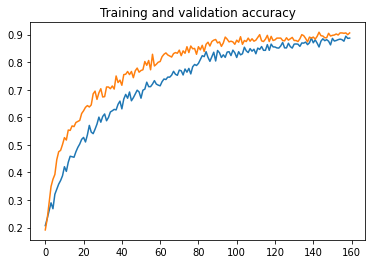

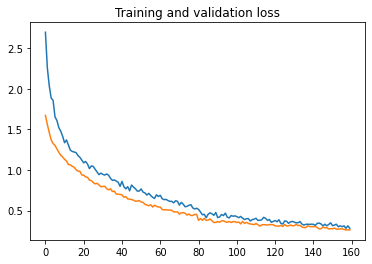

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title ('Training and validation loss')

In [ ]:
import numpy as np
import os
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/uploaded-test/' + fn
  uploaded_path = '/content/' + fn
  os.replace(uploaded_path, path)
  img = image.load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT))
  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes_pred = model.predict(images, batch_size=10)
  wayang_class = np.argmax(classes_pred)

  print('{} is {}'.format(fn, wayang_labels[wayang_class]))
  print(classes_pred)

Saving bagong (1).jpg to bagong (1).jpg
Saving bagong (4).jpg to bagong (4).jpg
Saving bagong (9).jpg to bagong (9).jpg
Saving bagong (16).jpg to bagong (16).jpg
Saving bagong (21).jpg to bagong (21).jpg
Saving bagong (25).jpg to bagong (25).jpg
Saving bagong (28).jpg to bagong (28).jpg
Saving gareng (2).jpg to gareng (2).jpg
Saving gareng (4).jpg to gareng (4).jpg
Saving gareng (9).jpg to gareng (9).jpg
Saving gareng (10).jpg to gareng (10).jpg
Saving gareng (21).jpg to gareng (21).jpg
Saving gareng (28).jpg to gareng (28).jpg
Saving petruk (3).jpg to petruk (3).jpg
Saving petruk (9).jpg to petruk (9).jpg
Saving petruk (10).jpg to petruk (10).jpg
Saving petruk (21).jpg to petruk (21).jpg
Saving petruk (22).jpg to petruk (22).jpg
Saving petruk (28).jpg to petruk (28).jpg
Saving semar (15).jpg to semar (15).jpg
Saving semar (21).jpg to semar (21).jpg
Saving semar (29).jpg to semar (29).jpg
bagong (1).jpg is semar
[[0.39341685 0.09682819 0.04205189 0.46770296]]
bagong (4).jpg is semar
[[

This following blocks are for testing purposes

In [ ]:
test_zip = '/content/wayang-test.zip'

zip_ref = zipfile.ZipFile(test_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
test_dir = '/content/test'

test_generator = train_datagen.flow_from_directory(test_dir,
                                                   batch_size=1,
                                                   class_mode='categorical',
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH)) 

Found 120 images belonging to 4 classes.


In [ ]:
model.evaluate(test_generator,
               batch_size=1,
               steps=120,
               verbose=1)

# model.evaluate(train_generator,
#                batch_size=train_batch,
#                steps=train_epoch,
#                verbose=2)

120/120 [==============================] - 1s 8ms/step - loss: 0.0411 - accuracy: 1.0000


[0.04113634675741196, 1.0]

The compiled model are converted into TFLite model, then saved into the system's directory.

In [ ]:
modelBaseName = 'wayang-mobilenet-v4'
modelTFLite = modelBaseName + '.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(modelTFLite, 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpl_kwrz9f/assets


Download converted model into your local system

In [ ]:
from google.colab import files

files.download(modelTFLite)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

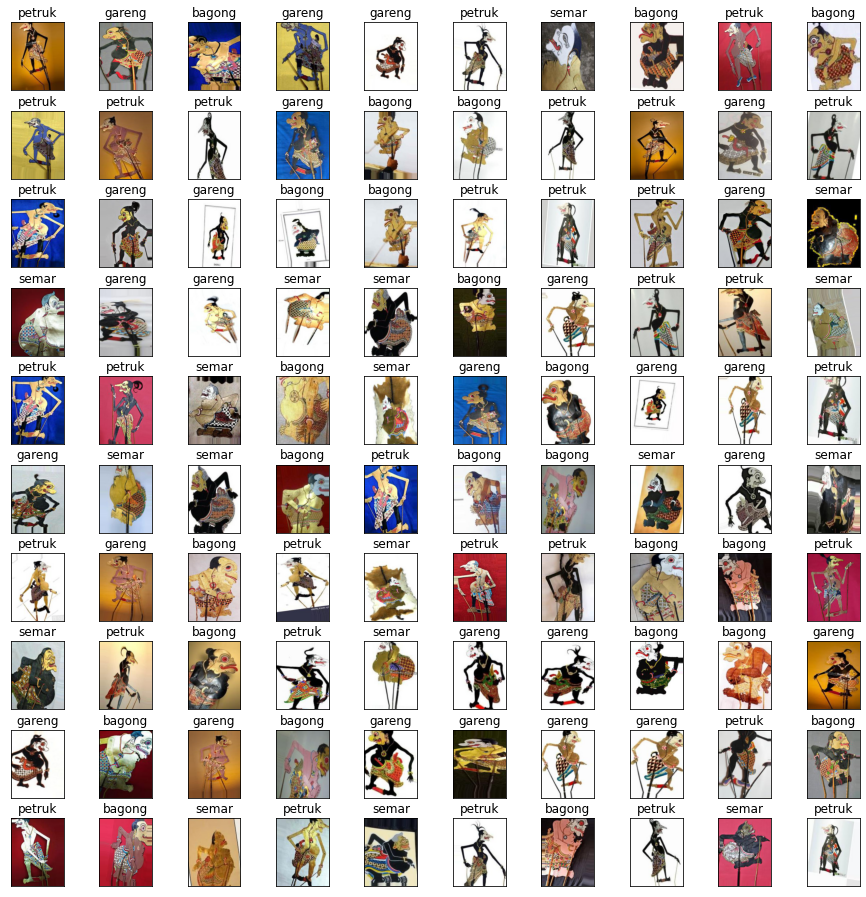

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
from IPython.core.display import display, HTML

rows = 10
cols = 10

plt.figure(figsize=(12, 12)) 

gspec = gridspec.GridSpec(
    rows,
    cols,
    wspace = 0.3,
    hspace = 0.3,
    top = 1.0,
    bottom = 0.0,
    left = 0.00, 
    right = 1.0,
) 

cnt = 0
for r in range(rows):
  for c in range(cols):
    batch = next(train_generator)
    img = batch[0][0]
    ax = plt.subplot(gspec[r, c])
    ax.set_title(wayang_labels[np.argmax(batch[1][0])])
    ax.imshow(img, cmap='gray')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    cnt = cnt + 1

plt.show()